In [1]:
!git clone https://github.com/mazout02/com2028-cw-data.git
# Clones data from a GitHub Repo

Cloning into 'com2028-cw-data'...
remote: Enumerating objects: 14994, done.
remote: Counting objects: 100% (14994/14994), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 14994 (delta 14967), reused 14994 (delta 14967), pack-reused 0
Receiving objects: 100% (14994/14994), 4.55 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (14967/14967), done.


In [3]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import random
import joblib  # store and load sklearn model


# Image processing
from skimage import data, io
from skimage.color import rgb2gray

# Plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})

# Machine learning
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.metrics import classification_report

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.layers import Rescaling, RandomZoom, RandomRotation, RandomFlip
from keras.callbacks import EarlyStopping
from keras import backend as K
!pip install tabulate
!pip install keras-tuner




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 16.4 MB/s eta 0:00:00


In [4]:
import tensorflow as tf

# check how many GPUs you have on the device
gpus = tf.config.list_physical_devices('GPU')
print("List of physical GPUs:", gpus)
print("Num GPUs Available: ", len(gpus))

if gpus:
  # Use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

tf.random.set_seed(42)

List of physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [5]:
# This will create a folder to keep the figures that are generated
def create_figures_directory():
    if not os.path.exists("plots"):
        os.mkdir("plots")

# This will create a folder to keep the figures that are generated

def save_figure(figure_name):
  plt.savefig(f'plots/{figure_name}.pdf' , bbox_inches= 'tight')
  print(f"The fig.s are located in 'plots/{figure_name}.pdf'")

def save_predictions_to_file(predictionArray, fileName):
    if os.path.exists(f"{fileName}.txt"):
        os.remove(f"{fileName}.txt")
    # Go through array, printing predictions to file
    for i in range(len(predictionArray)):
        # zfill for padding of index corresponding to test image number
        # Can uncomment the line below to print below as well as to file
        print(f"test/{str(i).zfill(5)}.jpg {predictionArray[i]}")
        with open(f"{fileName}.txt", "a") as myfile:
            # Print predictions to file in the format of train.txt
            myfile.write(f"test/{str(i).zfill(5)}.jpg {predictionArray[i]}" + "\n")

def get_train_labels():
  labels = []
  with open('com2028-cw-data/train.txt') as myfile:
    for line in myfile: 
      labels.append(int((line.strip()) [17:]))
      #print (theLine)
    #print(labels) 
  return labels

def load_train_images(): 
  images = []
  for i in range(10000):
    images.append(io.imread(f"com2028-cw-data/train/{str(i). zfill(6)}.jpg")) 
  return images
  
def load_test_images(): 
  images = []
  for i in range(5000):
    images.append(io.imread(f"com2028-cw-data/test/{str(i).zfill(5)}.jpg")) 
  return images
  def display_image(number): 
    io.imshow(number)     
       
create_figures_directory()

In [6]:
#This function loads the training images and labels
def load_dataset():
  data = load_train_images()
  target = get_train_labels()
  return data, target

#This function loads, encodes, and splits the training dataset for training and validation
def load_encode_dataset():
  X, y = load_dataset() 
  X = np.array(X)
  y = np.array(y)
  X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3)
  y_train = to_categorical(y_train)
  y_validate = to_categorical (y_validate) 
  return X_train, X_validate, y_train, y_validate

#This function loads the test images
def load_test():
  data = load_test_images()
  return data

In [7]:
from tabulate import tabulate
# Function to evaluate the model performance
def evaluateModel(model, X_test_data, y_test_data, training_history, fig_name):
    model.evaluate(X_test_data, y_test_data)
    y_pred = model.predict(X_test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_data, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, labels=list(range(8)), output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Display the classification report in a table format
    print("Classification Report:")
    print(tabulate(report_df, headers='keys', tablefmt='psql', floatfmt=".2f"))

    # Calculate the confusion matrix and normalize it
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, normalize='pred')
    
    # Display the confusion matrix
    cm_display = ConfusionMatrixDisplay(conf_matrix)
    cm_display.plot(include_values=False, cmap='Reds')
    save_figure(f"{fig_name}-CM")
    plt.show()

    # Extract accuracy and loss values from training history
    train_acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    # Plot accuracy and loss values over time
    plt.figure(figsize=(8, 8))
    plt.plot(train_acc, label='Training Accuracy', linestyle="--")
    plt.plot(val_acc, label='Validation Accuracy', linestyle="-.")
    plt.plot(train_loss, label='Training Loss', linestyle=":")
    plt.plot(val_loss, label='Validation Loss', linestyle="-")
    plt.legend(loc='upper right', fontsize=12)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy/Loss Score", fontsize=12)
    plt.title('Training & Validation Accuracy and Loss', fontweight="bold", fontsize=14)
    plt.gca().set_facecolor("#F5F5F5")
    plt.grid(color="white", linestyle="--", linewidth=1)
    save_figure(f"{fig_name}-LearningCurves")
    plt.show()

    # Save the predictions to a file
    save_predictions_to_file(y_pred_classes, f"{fig_name}")

# New data augmentation pipeline
data_preprocessing = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"), 
  layers.RandomRotation(0.1),
])


In [8]:
def modelTestEval(modelFileName, filename):
  X_test = load_test() 
  X_test = np.array(X_test)
  print(X_test.shape)
  model = load_model(f'{modelFileName}.h5') 
  y_prediction = model.predict(X_test)
  y_prediction = np.argmax (y_prediction, axis= 1) 
  save_predictions_to_file (y_prediction, f"{filename}")

# CREATE THE CNN MODEL

In [9]:
def create_CNN_model():
    cnn_model = Sequential([data_preprocessing])
    
    cnn_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(28, 28, 3), padding="same"))
    cnn_model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same"))
    cnn_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    cnn_model.add(Conv2D(64, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1), padding="same"))
    cnn_model.add(Conv2D(64, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1), padding="same"))
    cnn_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    cnn_model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
    cnn_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    cnn_model.add(Dense(8, activation="softmax"))
    
    cnn_model.compile(optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

In [10]:
def testingModel(modelFileName, filename):
  X_test = load_test() 
  X_test = np.array(X_test)
  print(X_test.shape)
  model = load_model(f'{modelFileName}.h5') 
  y_prediction = model.predict(X_test)
  y_prediction = np.argmax (y_prediction, axis= 1) 
  save_predictions_to_file (y_prediction, f"{filename}")

In [11]:
def run_testing_1():
    name = "CNN-Modified"
    X_train, X_validate, y_train, y_validate = load_encode_dataset() 
    model = create_CNN_model()
    
    # Using a learning rate scheduler
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    
    history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=100, batch_size=128, callbacks=[lr_scheduler])
    evaluateModel(model,X_validate, y_validate, history, name)
    model.save(f'{name}.h5')

Epoch 1/100
55/55 [==============================] - 15s 26ms/step - loss: 2.1833 - accuracy: 0.1897 - val_loss: 2.1167 - val_accuracy: 0.2157 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 1s 13ms/step - loss: 1.9621 - accuracy: 0.3247 - val_loss: 1.6966 - val_accuracy: 0.4277 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 1s 13ms/step - loss: 1.4485 - accuracy: 0.5116 - val_loss: 1.1693 - val_accuracy: 0.6293 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 1s 13ms/step - loss: 1.1303 - accuracy: 0.6437 - val_loss: 1.0059 - val_accuracy: 0.6913 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 1s 13ms/step - loss: 0.9907 - accuracy: 0.6937 - val_loss: 0.8979 - val_accuracy: 0.7337 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 1s 13ms/step - loss: 0.9249 - accuracy: 0.7234 - val_loss: 0.9686 - val_accuracy: 0.7010 - lr: 0.0100
Epoch 7/100
55/55 [==============================] - 1s 13ms/step - l

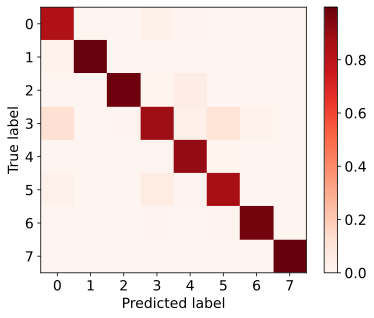

The fig.s are located in 'plots/CNN-Modified-LearningCurves.pdf'


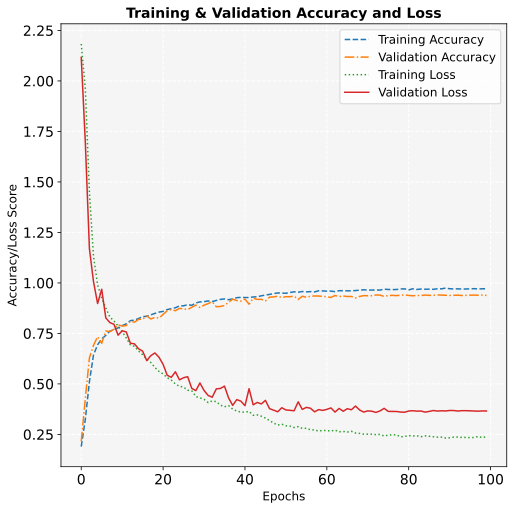

test/00000.jpg 3
test/00001.jpg 6
test/00002.jpg 3
test/00003.jpg 6
test/00004.jpg 7
test/00005.jpg 1
test/00006.jpg 4
test/00007.jpg 3
test/00008.jpg 5
test/00009.jpg 5
test/00010.jpg 5
test/00011.jpg 3
test/00012.jpg 2
test/00013.jpg 7
test/00014.jpg 0
test/00015.jpg 2
test/00016.jpg 6
test/00017.jpg 6
test/00018.jpg 3
test/00019.jpg 7
test/00020.jpg 2
test/00021.jpg 6
test/00022.jpg 7
test/00023.jpg 3
test/00024.jpg 4
test/00025.jpg 1
test/00026.jpg 6
test/00027.jpg 6
test/00028.jpg 4
test/00029.jpg 3
test/00030.jpg 6
test/00031.jpg 3
test/00032.jpg 1
test/00033.jpg 5
test/00034.jpg 1
test/00035.jpg 1
test/00036.jpg 1
test/00037.jpg 2
test/00038.jpg 6
test/00039.jpg 6
test/00040.jpg 7
test/00041.jpg 3
test/00042.jpg 6
test/00043.jpg 0
test/00044.jpg 7
test/00045.jpg 0
test/00046.jpg 5
test/00047.jpg 7
test/00048.jpg 4
test/00049.jpg 1
test/00050.jpg 3
test/00051.jpg 7
test/00052.jpg 6
test/00053.jpg 4
test/00054.jpg 7
test/00055.jpg 3
test/00056.jpg 3
test/00057.jpg 3
test/00058.jpg

In [12]:
run_testing_1()

In [13]:
modelTestEval("CNN-Modified", "test")

Streaming output truncated to the last 5000 lines.
test/00000.jpg 1
test/00001.jpg 3
test/00002.jpg 6
test/00003.jpg 3
test/00004.jpg 7
test/00005.jpg 3
test/00006.jpg 5
test/00007.jpg 0
test/00008.jpg 7
test/00009.jpg 2
test/00010.jpg 1
test/00011.jpg 1
test/00012.jpg 6
test/00013.jpg 3
test/00014.jpg 6
test/00015.jpg 2
test/00016.jpg 3
test/00017.jpg 6
test/00018.jpg 6
test/00019.jpg 7
test/00020.jpg 7
test/00021.jpg 0
test/00022.jpg 3
test/00023.jpg 2
test/00024.jpg 4
test/00025.jpg 6
test/00026.jpg 0
test/00027.jpg 0
test/00028.jpg 4
test/00029.jpg 1
test/00030.jpg 3
test/00031.jpg 1
test/00032.jpg 1
test/00033.jpg 4
test/00034.jpg 3
test/00035.jpg 6
test/00036.jpg 2
test/00037.jpg 2
test/00038.jpg 1
test/00039.jpg 7
test/00040.jpg 7
test/00041.jpg 2
test/00042.jpg 3
test/00043.jpg 7
test/00044.jpg 4
test/00045.jpg 5
test/00046.jpg 4
test/00047.jpg 1
test/00048.jpg 6
test/00049.jpg 6
test/00050.jpg 1
test/00051.jpg 3
test/00052.jpg 6
test/00053.jpg 1
test/00054.jpg 2
test/00055.jpg